In [1]:
import numpy as np
import pickle
import operator

question = np.load('pad_question.npy')
answer = np.load('pad_answer.npy')
answer_o = np.load('answer_o.npy')
with open('vocab_bag.pkl', 'rb') as f:
    words = pickle.load(f)
with open('pad_word_to_index.pkl', 'rb') as f:
    word_to_index = pickle.load(f)
with open('pad_index_to_word.pkl', 'rb') as f:
    index_to_word = pickle.load(f)
vocab_size = len(word_to_index) + 1
maxLen=20

In [2]:
from keras.preprocessing import sequence
def generate_train(batch_size):
    print('\n*********************************generate_train()*********************************')
    steps=0
    question_ = question
    answer_ = answer
    while True:
        batch_answer_o = answer_o[steps:steps+batch_size]
        batch_question = question_[steps:steps+batch_size]
        batch_answer = answer_[steps:steps+batch_size]
        outs = np.zeros([batch_size, maxLen, vocab_size], dtype='float32')
        for pos, i in enumerate(batch_answer_o):
            for pos_, j in enumerate(i):
                if pos_ > 20:
                    print(i)
                outs[pos, pos_, j] = 1 # one-hot
        yield [batch_question, batch_answer], outs
        steps += batch_size
        if steps == 100000:
            steps = 0

Using TensorFlow backend.


In [3]:
from keras.layers import Embedding
from keras.layers import Input, Dense, LSTM, TimeDistributed, Bidirectional, Dropout, Concatenate, RepeatVector, Activation, Dot
from keras.layers import concatenate, dot                    
from keras.models import Model
from keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.initializers import TruncatedNormal
import pydot
import os, re

In [4]:
truncatednormal = TruncatedNormal(mean=0.0, stddev=0.05)
embed_layer = Embedding(input_dim=vocab_size, 
                        output_dim=100, 
                        mask_zero=True,
                        input_length=None,
                        embeddings_initializer= truncatednormal)
LSTM_encoder = LSTM(512,
                      return_sequences=True,
                      return_state=True,
                      kernel_initializer= 'lecun_uniform',
                      name='encoder_lstm'
                        )
LSTM_decoder = LSTM(512, 
                    return_sequences=True, 
                    return_state=True, 
                    kernel_initializer= 'lecun_uniform',
                    name='decoder_lstm'
                   )

#encoder输入 与 decoder输入
input_question = Input(shape=(None, ), dtype='int32', name='input_question')
input_answer = Input(shape=(None, ), dtype='int32', name='input_answer')

input_question_embed = embed_layer(input_question)
input_answer_embed = embed_layer(input_answer)


encoder_lstm, question_h, question_c = LSTM_encoder(input_question_embed)

decoder_lstm, _, _ = LSTM_decoder(input_answer_embed, 
                                  initial_state=[question_h, question_c])

attention = dot([decoder_lstm, encoder_lstm], axes=[2, 2])
attention = Activation('softmax')(attention)
context = dot([attention, encoder_lstm], axes=[2,1])
decoder_combined_context = concatenate([context, decoder_lstm])


# Has another weight + tanh layer as described in equation (5) of the paper
decoder_dense1 = TimeDistributed(Dense(256,activation="tanh"))
decoder_dense2 = TimeDistributed(Dense(vocab_size,activation="softmax"))
output = decoder_dense1(decoder_combined_context) # equation (5) of the paper
output = decoder_dense2(output) # equation (6) of the paper

model = Model([input_question, input_answer], output)

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

model.load_weights('models/W--184-0.5949-.h5')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
input_question (InputLayer)     (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    4335000     input_question[0][0]             
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder_lstm (LSTM)             [(Non

In [5]:
question_model = Model(input_question, [encoder_lstm, question_h, question_c])
question_model.summary()
answer_h = Input(shape=(512,))
answer_c = Input(shape=(512,))
encoder_lstm = Input(shape=(maxLen,512))
target, h, c = LSTM_decoder(input_answer_embed, initial_state=[answer_h, answer_c])
attention = dot([target, encoder_lstm], axes=[2, 2])
attention_ = Activation('softmax')(attention)
context = dot([attention_, encoder_lstm], axes=[2,1])
decoder_combined_context = concatenate([context, target])
output = decoder_dense1(decoder_combined_context) # equation (5) of the paper
output = decoder_dense2(output) # equation (6) of the paper
answer_model = Model([input_answer, answer_h, answer_c, encoder_lstm], [output, h, c, attention_])
answer_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_question (InputLayer)  (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 100)         4335000   
_________________________________________________________________
encoder_lstm (LSTM)          [(None, None, 512), (None 1255424   
Total params: 5,590,424
Trainable params: 5,590,424
Non-trainable params: 0
_________________________________________________________________
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________


In [6]:
from keras.preprocessing import sequence
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import jieba
import requests
def act_weather(city):
    #TODO: Get weather by api
    url = 'http://wthrcdn.etouch.cn/weather_mini?city=' + city
    page = requests.get(url)
    data = page.json()
    temperature = data['data']['wendu']
    notice = data['data']['ganmao']
    outstrs = "地点： %s\n气温： %s\n注意： %s" % (city, temperature, notice)
    return outstrs + ' EOS'
def input_question(seq):
    seq = jieba.lcut(seq.strip(), cut_all=False)
    sentence = seq
    try:
        seq = np.array([word_to_index[w] for w in seq])
    except KeyError:
        seq = np.array([36874, 165, 14625])
    seq = sequence.pad_sequences([seq], maxlen=maxLen,
                                          padding='post', truncating='post')
    print(seq)
    return seq, sentence
def decode_greedy(seq, sentence):
    question = seq
    for index in question[0]:
        if int(index) == 5900:
            for index_ in question[0]:
                if index_ in [7851, 11842,2406, 3485, 823, 12773, 8078]:
                    return act_weather(index_to_word[index_])
    answer = np.zeros((1, 1))
    attention_plot = np.zeros((20, 20))
    answer[0, 0] = word_to_index['BOS']
    i=1
    answer_ = []
    flag = 0
    encoder_lstm_, question_h, question_c = question_model.predict(x=question, verbose=1)
#     print(question_h, '\n')
    while flag != 1:
        prediction, prediction_h, prediction_c, attention = answer_model.predict([
            answer, question_h, question_c, encoder_lstm_
        ])
        attention_weights = attention.reshape(-1, )
        attention_plot[i] = attention_weights
        word_arg = np.argmax(prediction[0, -1, :])#
        answer_.append(index_to_word[word_arg])
        if word_arg == word_to_index['EOS']  or i > 20:
            flag = 1
        answer = np.zeros((1, 1))
        answer[0, 0] = word_arg
        question_h = prediction_h
        question_c = prediction_c
        i += 1
    result = ' '.join(answer_)
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence)]
    plot_attention(attention_plot, sentence, result.split(' '))
    return ' '.join(answer_)
def decode_beamsearch(seq, beam_size):
    question = seq
    encoder_lstm_, question_h, question_c = question_model.predict(x=question, verbose=1)
    sequences = [[[word_to_index['BOS']], 1.0, question_h, question_c]]
    answer = np.zeros((1, 1))
    answer[0, 0] = word_to_index['BOS']
    answer_ = ''
    flag = 0
    last_words = [word_to_index['BOS']]
    for i in range(maxLen):
        all_candidates = []
        for j in range(len(sequences)):
            s, score, h, c = sequences[j]
            last_word = s[-1]
            if not isinstance(last_word, int):
                last_word=last_word[-1]
            answer[0, 0] = last_word
            output, h, c, _ = answer_model.predict([answer, h, c, encoder_lstm_])
            output = output[0, -1]
            for k in range(len(output)):
                candidate = [seq+[k], score*-np.log(output[k]), h, c]
            all_candidates.append(candidate)
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        sequences = ordered[:beam_size]
    answer_ = sequences[0][0]
    print(answer_[0])
    answer_ = [index_to_word[x] for x in answer_[0] if (x!=0)]
    answer_ = ' '.join(answer_)
    return answer_
def plot_attention(attention, sentence, predicted_sentence):
    zhfont = matplotlib.font_manager.FontProperties(fname='simkai.ttf')
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    attention = [x[::-1] for x in attention]
    ax.matshow(attention, cmap='viridis')
    fontdict = {'fontsize': 20}
    ax.set_xticklabels([''] + sentence, fontdict=fontdict,fontproperties=zhfont)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=zhfont)
#     ax.yaxis.set_ticks_position('right') #y轴刻度位置靠右
    plt.show()

你身高多少
[[  10 8113  123    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['你', '身高', '多少']
1/1 [==============================] - 0s 6ms/step


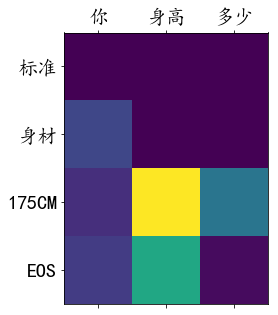

ANSWER:  标准 身材 175CM EOS
你是人类么
[[  10   29 2659  126    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['你', '是', '人类', '么']
1/1 [==============================] - 0s 7ms/step


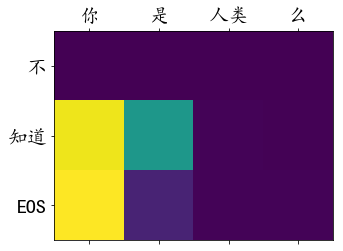

ANSWER:  不 知道 EOS
我恨你
[[  56 4127   10    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['我', '恨', '你']
1/1 [==============================] - 0s 7ms/step


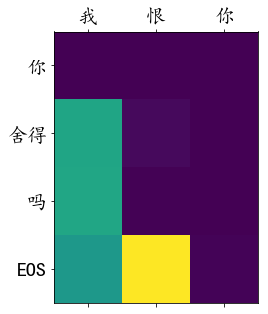

ANSWER:  你 舍得 吗 EOS
我生气了
[[  56 2074   57    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['我', '生气', '了']
1/1 [==============================] - 0s 7ms/step


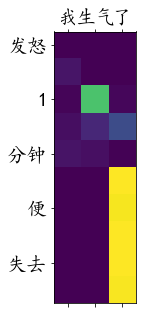

ANSWER:  发怒 1 分钟 便 失去 60 秒 的 幸福 EOS
哄哄我
[[11692    56     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
['哄哄', '我']
1/1 [==============================] - 0s 6ms/step


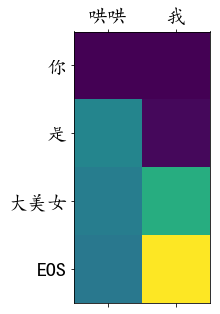

ANSWER:  你 是 大美女 EOS
你饿不饿啊
[[ 10 729  36 729 128   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
['你', '饿', '不', '饿', '啊']
1/1 [==============================] - 0s 11ms/step


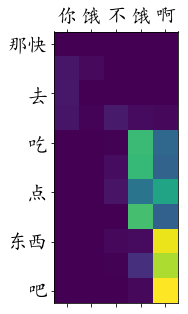

ANSWER:  那快 去 吃 点 东西 吧 别老 玩 QQ 了 EOS
我好饿啊
[[ 56 361 729 128   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
['我', '好', '饿', '啊']
1/1 [==============================] - 0s 10ms/step


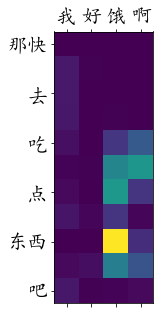

ANSWER:  那快 去 吃 点 东西 吧 别老 玩 QQ 了 EOS
我恨你
[[  56 4127   10    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['我', '恨', '你']
1/1 [==============================] - 0s 5ms/step


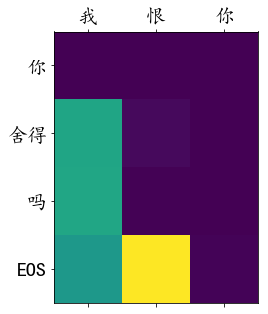

ANSWER:  你 舍得 吗 EOS
今天天气好差
[[20439 15027     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
['今天天气', '好差']
1/1 [==============================] - 0s 8ms/step


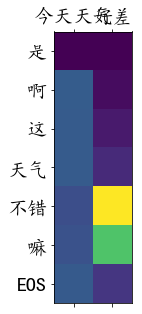

ANSWER:  是 啊 这 天气 不错 嘛 EOS
今天天气真差
[[36874   165 14625     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]]
['今天天气', '真差']
1/1 [==============================] - 0s 9ms/step


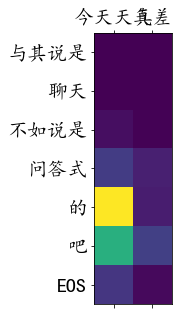

ANSWER:  与其说是 聊天 不如说是 问答式 的 吧 EOS
一起去吃饭吧
[[1654  147  230  194    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['一起', '去', '吃饭', '吧']
1/1 [==============================] - 0s 8ms/step


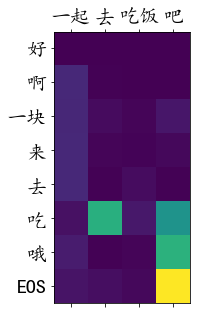

ANSWER:  好 啊 一块 来 去 吃 哦 EOS
你吃饱了没
[[  10 3964   57   61    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['你', '吃饱', '了', '没']
1/1 [==============================] - 0s 14ms/step


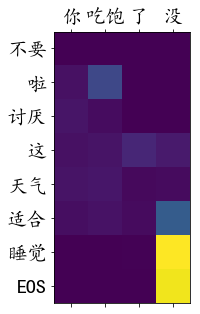

ANSWER:  不要 啦 讨厌 这 天气 适合 睡觉 EOS
你吃饱了么
[[  10 3964   57  126    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['你', '吃饱', '了', '么']
1/1 [==============================] - 0s 12ms/step


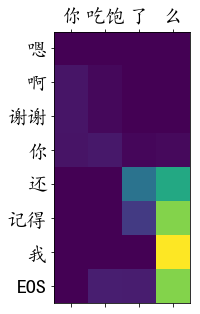

ANSWER:  嗯 啊 谢谢 你 还 记得 我 EOS
哈哈哈
[[1018    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['哈哈哈']
1/1 [==============================] - 0s 11ms/step


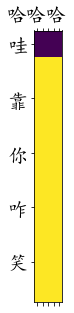

ANSWER:  哇 靠 你 咋 笑 得 这么 猥琐 ~ EOS
哈哈
[[1265    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
['哈哈']
1/1 [==============================] - 0s 8ms/step


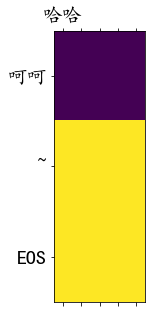

ANSWER:  呵呵 ~ EOS
你好
[[829   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
['你好']
1/1 [==============================] - 0s 9ms/step


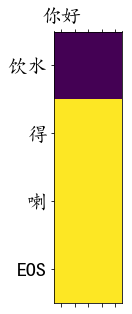

ANSWER:  饮水 得 喇 EOS
你在干嘛呢
[[ 10   2 229 171   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
['你', '在', '干嘛', '呢']
1/1 [==============================] - 0s 9ms/step


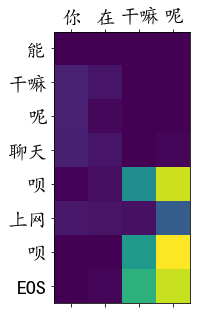

ANSWER:  能 干嘛 呢 聊天 呗 上网 呗 EOS
x


In [11]:
while True:
    seq = input()
    if seq == 'x':
        break
    seq, sentence = input_question(seq)
    print(sentence)
    answer = decode_greedy(seq, sentence)
#     answer=decode_beamsearch(seq, 3)
    print('ANSWER: ', answer)

Building prefix dict from the default dictionary ...
Loading model from cache E:\Temp\jieba.cache


哈哈



Loading model cost 0.897 seconds.
Prefix dict has been built succesfully.


[[1265    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
1/1 [==============================] - 0s 155ms/step


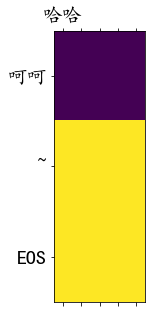

呵呵 ~ EOS


In [7]:
from tkinter import Text, Entry, Button, StringVar, Scrollbar, END
from tkinter.messagebox import showinfo
import tkinter as tk
root = tk.Tk()
root.title("聊天机器人-小意")
root.geometry("425x385")
root.resizable(0,0)
root.attributes('-toolwindow', True,
                '-alpha', 1,
                '-fullscreen', False, 
                '-topmost', True)
showinfo('Hello', '[小意]准备好了！')
root.overrideredirect(True)
def center_window(w, h):
    ws = root.winfo_screenwidth()
    hs = root.winfo_screenheight()
    x = (ws/2) - (w/2)
    y = (hs/2) - (h/2)
    root.geometry('%dx%d+%d+%d' % (w, h, x, y))
center_window(425, 356)
text_recv = Text(root, width=61, height=20, bd=0, selectbackground='#00BFFF')
text_recv.place(x=0, y=0)
text_recv.tag_config('me_msg', 
                     foreground='#000000', 
#                      background='#00BFFF',
                     justify='right', 
                     rmargin=20,
                     offset=10,
                     borderwidth=10)

text_msg = Text(root, width=61, height=6, bd=0)
text_msg.place(x=0, y=275)


def show():
    seq = text_msg.get("0.0", "end")
    msg_send = seq
    print(msg_send)
    text_recv.insert(END, msg_send, 'me_msg')
    seq, sentence = input_question(seq)
    answer = decode_greedy(seq, sentence)
    print(answer)
    answer = ''.join(answer.split(' ')[:-1])
    msg_recv = '[小意]: '+ answer + '\n'
    text_recv.insert(END, msg_recv)
    text_msg.delete("0.0", "end")
Button(root,text='发送信息',width=10,command=show, 
       bd=0, bg='#00BFFF', fg='#FFFFFF',
       activeforeground='#1E90FF').place(x=340,y=330)
Button(root,text='quit',width=10,command=root.destroy, 
       bd=0, bg='#00BFFF', fg='#FFFFFF',
       activeforeground='#1E90FF').place(x=20,y=330)
Button(root, text="清屏",width=10,command = lambda : text_recv.delete(0.0, END),
       bd=0, bg='#00BFFF', fg='#FFFFFF',
       activeforeground='#1E90FF').place(x=240,y=330)
root.mainloop()
